# CNN Exercise 2: Image Classification with CNNs - Solution

The dataset is the CIFAR10 dataset, which consists of 60000 colour images in 10 classes, with 6000 images per class. There are 50000 training images and 10000 test images. The classes are: airplane, automobile, bird, cat, deer, dog, frog, horse, ship, truck. In this exercise we will only use the dog and cat classes and we will train a CNN to distinguish between the two.

In the following cell we load the dataset again from ```torchvision.datasets```. There is a bunch of code that is not relevant for this exercise, but you can have a look at it if you are interested. The important part is that we load training and test data, only select the dog and cat classes, and do some augmentation and normalizing of the data.

Thanks to [this Gist](https://gist.github.com/Miladiouss/6ba0876f0e2b65d0178be7274f61ad2f) for the code to load the CIFAR10 dataset.

Created by Cedric Ewen in 2023


In [1]:
# imports
import torch
import torchvision
import torchvision.transforms as transforms
from torchvision.datasets import CIFAR10
from torch.utils.data import Dataset, DataLoader
import numpy as np

In [2]:
# device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
# Transformations
RC = transforms.RandomCrop(32, padding=4)
RHF = transforms.RandomHorizontalFlip()
RVF = transforms.RandomVerticalFlip()
NRM = transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) #transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))
TT = transforms.ToTensor()
TPIL = transforms.ToPILImage()

# Transforms object for trainset with augmentation
transform_with_aug = transforms.Compose([TPIL, RC, RHF, TT, NRM])
# Transforms object for testset with NO augmentation
transform_no_aug = transforms.Compose([TT, NRM])

# Downloading/Louding CIFAR10 data
# , transform = transform_with_aug)
trainset = CIFAR10(root='./data', train=True, download=True)
# , transform = transform_no_aug)
testset = CIFAR10(root='./data', train=False, download=True)


# Separating trainset/testset data/label
x_train = trainset.data
x_test = testset.data
y_train = trainset.targets
y_test = testset.targets

Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Define a function to separate CIFAR classes by class index

def get_class_i(x, y, i):
    """
    x: trainset.train_data or testset.test_data
    y: trainset.train_labels or testset.test_labels
    i: class label, a number between 0 to 9
    return: x_i
    """
    # Convert to a numpy array
    y = np.array(y)
    # Locate position of labels that equal to i
    pos_i = np.argwhere(y == i)
    # Convert the result into a 1-D list
    pos_i = list(pos_i[:, 0])
    # Collect all data that match the desired label
    x_i = [x[j] for j in pos_i]

    return x_i


class DatasetMaker(Dataset):
    def __init__(self, datasets, transformFunc=transform_no_aug):
        """
        datasets: a list of get_class_i outputs, i.e. a list of list of images for selected classes
        """
        self.datasets = datasets
        self.lengths = [len(d) for d in self.datasets]
        self.transformFunc = transformFunc

    def __getitem__(self, i):
        class_label, index_wrt_class = self.index_of_which_bin(self.lengths, i)
        img = self.datasets[class_label][index_wrt_class]
        img = self.transformFunc(img)
        return img, class_label

    def __len__(self):
        return sum(self.lengths)

    def index_of_which_bin(self, bin_sizes, absolute_index, verbose=False):
        """
        Given the absolute index, returns which bin it falls in and which element of that bin it corresponds to.
        """
        # Which class/bin does i fall into?
        accum = np.add.accumulate(bin_sizes)
        if verbose:
            print("accum =", accum)
        bin_index = len(np.argwhere(accum <= absolute_index))
        if verbose:
            print("class_label =", bin_index)
        # Which element of the fallent class/bin does i correspond to?
        index_wrt_class = absolute_index - np.insert(accum, 0, 0)[bin_index]
        if verbose:
            print("index_wrt_class =", index_wrt_class)

        return bin_index, index_wrt_class

Uncomment the second line in the cell below for the follow-up exercise.

In [5]:
classDict = {'cat': 3, 'dog': 5}
classDict = {'plane': 0, 'car': 1, 'bird': 2, 'cat': 3, 'deer': 4, 'dog': 5, 'frog': 6, 'horse': 7, 'ship': 8, 'truck': 9}

In [6]:
classes = [key for key in classDict.keys()]
batch_size = 64
    
trainset = DatasetMaker([get_class_i(x_test, y_test, classDict[class_name]) 
                         for class_name in classes], transform_no_aug)
testset = DatasetMaker([get_class_i(x_test, y_test, classDict[class_name]) 
                        for class_name in classes], transform_no_aug)

kwargs = {'num_workers': 2, 'pin_memory': False}
print(classes)
# Create datasetLoaders from trainset and testset
trainloader = DataLoader(
    trainset, batch_size=batch_size, shuffle=True, **kwargs)
testloader = DataLoader(
    testset, batch_size=batch_size, shuffle=True, **kwargs)

['plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


We now have a training and test set of only cats and dogs. Cats have label 0, while dogs have label 1. Let's look at some of the images.
- What's the size of the images?
- How many images do we have in training and test set?

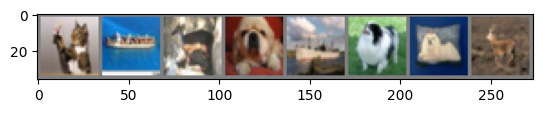

cat   ship  deer  dog   ship  dog   dog   deer 


In [7]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

# get some random training images
dataiter = iter(trainloader)

images, labels = next(dataiter)

images_to_plot = 8

# show images
imshow(torchvision.utils.make_grid(images[:images_to_plot]))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(images_to_plot)))

In [8]:
#print(images.shape)
#print(len(dataiter))

In [9]:
#for count, i in enumerate(testloader):
#    print(count, i[0].shape)

# Define the Network
This is the only area you will need to change

In [10]:
import torch.nn as nn
import torch.nn.functional as F
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        # define the layers
        self.conv1 = nn.Sequential(         
            nn.Conv2d(
                in_channels=3,              
                out_channels=8,            
                kernel_size=3,              
                stride=1,                   
                padding="same",                  
            ),                             
            nn.ReLU(),                      
        )
        self.pool1 = nn.AvgPool2d(kernel_size=2, stride=2)  
        self.conv2 = nn.Sequential(         
            nn.Conv2d(
                in_channels=8,              
                out_channels=16,            
                kernel_size=3,              
                stride=1,                   
                padding="same",                  
            ),                              
            nn.ReLU(),                        
        )
        self.pool2 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.conv3 = nn.Sequential(         
            nn.Conv2d(
                in_channels=16,              
                out_channels=32,            
                kernel_size=3,              
                stride=1,                   
                padding="same",                  
            ),                              
            nn.ReLU(),                        
        )
        self.pool3 = nn.AvgPool2d(kernel_size=2, stride=2)
        
        self.out = nn.Sequential(        
            nn.Dropout(0.5),
            nn.Linear(512, 20),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(20, 10),
            nn.Softmax(dim=-1)
        )

    def forward(self, x):
        x = self.conv1(x)
        x = self.pool1(x)
        x = self.conv2(x)
        x = self.pool2(x)
        x = self.conv3(x)
        x = self.pool3(x)
        x = x.view(x.size(0), -1)   
        output = self.out(x)
        return output

In [11]:
model = CNN()
print(model)

CNN(
  (conv1): Sequential(
    (0): Conv2d(3, 8, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (pool1): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv2): Sequential(
    (0): Conv2d(8, 16, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (pool2): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (conv3): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=same)
    (1): ReLU()
  )
  (pool3): AvgPool2d(kernel_size=2, stride=2, padding=0)
  (out): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=512, out_features=20, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=20, out_features=10, bias=True)
    (5): Softmax(dim=-1)
  )
)


In [12]:
from torchsummary import summary
summary(model, (3, 32, 32), batch_size=batch_size, device='cpu')

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [64, 8, 32, 32]             224
              ReLU-2            [64, 8, 32, 32]               0
         AvgPool2d-3            [64, 8, 16, 16]               0
            Conv2d-4           [64, 16, 16, 16]           1,168
              ReLU-5           [64, 16, 16, 16]               0
         AvgPool2d-6             [64, 16, 8, 8]               0
            Conv2d-7             [64, 32, 8, 8]           4,640
              ReLU-8             [64, 32, 8, 8]               0
         AvgPool2d-9             [64, 32, 4, 4]               0
          Dropout-10                  [64, 512]               0
           Linear-11                   [64, 20]          10,260
             ReLU-12                   [64, 20]               0
          Dropout-13                   [64, 20]               0
           Linear-14                   

# Training

In [13]:
loss_func = nn.CrossEntropyLoss()   
loss_func

CrossEntropyLoss()

In [14]:
# move model to GPU
model = model.to(device)

In [15]:
from torch import optim
optimizer = optim.Adam(model.parameters(), lr = 0.001)   
optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: False
    lr: 0.001
    maximize: False
    weight_decay: 0
)

The training loop is the same as in the previous exercise. The only difference is that we have added a validation epoch, where we evaluate the model on the validation set (in our case the test data). We additionally save the loss and accuracy for both the training and validation set in a list, so that we can plot them later. The accuracy is calculated as the number of correctly classified images divided by the total number of images.

In [23]:
def train(num_epochs, model, trainloader, testloader):
    
    
    train_losses = []
    train_accuracy = []
    
    val_losses = []
    val_accuracy = []
        
    # Train the model    
    for epoch in range(num_epochs):
        
        # training
        model.train()
        train_loss = 0.0
        train_acc = 0.0
        for i, (images, labels) in enumerate(trainloader, 0):
            
            # move data to GPU
            images = images.to(device)
            labels = labels.to(device)
            
            # run model
            output = model(images)     
            # compute loss          
            loss = loss_func(output, labels)
            
            # clear gradients for this training step   
            optimizer.zero_grad()           
            
            # backpropagation, compute gradients 
            loss.backward()    
            # apply gradients             
            optimizer.step()   
            
            # save metrics for ploting
            train_loss += loss.item()
            train_acc += (output.argmax(dim=1) == labels).float().mean().item()
            
        train_loss = train_loss / len(trainloader)
        train_acc = train_acc / len(trainloader)
        train_losses.append(train_loss)
        train_accuracy.append(train_acc)
        
        # validation 
        model.eval()
        with torch.no_grad():
            val_loss = 0.0  
            val_acc = 0.0
            for i, (images, labels) in enumerate(testloader, 0):  
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images)
                v_loss = loss_func(pred, labels)
                val_loss += v_loss.item()
                val_acc += (pred.argmax(dim=1) == labels).float().mean().item()
                
            val_loss = val_loss / len(testloader)
            val_acc = val_acc / len(testloader)
            val_losses.append(val_loss)     
            val_accuracy.append(val_acc)   

        print(f"Epoch: {epoch+1}/{num_epochs} | loss: {train_loss} - acc: {train_acc} | val_loss: {val_loss} - val_acc: {val_acc}")
    
    print(f"Finished training after {num_epochs} epochs")
    print(f"Best validation accuracy: {max(val_accuracy)}")
    return train_losses, val_losses, train_accuracy, val_accuracy

num_epochs = 100
train_losses, val_losses, train_accuracy, val_accuracy = train(num_epochs, model, trainloader, testloader)

Epoch: 1/100 | loss: 2.0663638600877894 - acc: 0.38495222929936307 | val_loss: 1.9854443916089974 - val_acc: 0.4724323248407643
Epoch: 2/100 | loss: 2.056436471878343 - acc: 0.39470541401273884 | val_loss: 1.9858441504703206 - val_acc: 0.47153662420382164
Epoch: 3/100 | loss: 2.062993599351045 - acc: 0.39072452229299365 | val_loss: 1.9826348101257518 - val_acc: 0.4778065286624204
Epoch: 4/100 | loss: 2.0552349956172287 - acc: 0.3973925159235669 | val_loss: 1.9757549519751483 - val_acc: 0.48447452229299365
Epoch: 5/100 | loss: 2.0580657173873513 - acc: 0.3963972929936306 | val_loss: 1.9732171122435551 - val_acc: 0.4850716560509554
Epoch: 6/100 | loss: 2.058417929205925 - acc: 0.3938097133757962 | val_loss: 1.9695483074066744 - val_acc: 0.4901472929936306
Epoch: 7/100 | loss: 2.0555570414111872 - acc: 0.39729299363057324 | val_loss: 1.9728026754537207 - val_acc: 0.4880573248407643
Epoch: 8/100 | loss: 2.0579119579047913 - acc: 0.39540207006369427 | val_loss: 1.9751190106580212 - val_acc:

# Evaluation

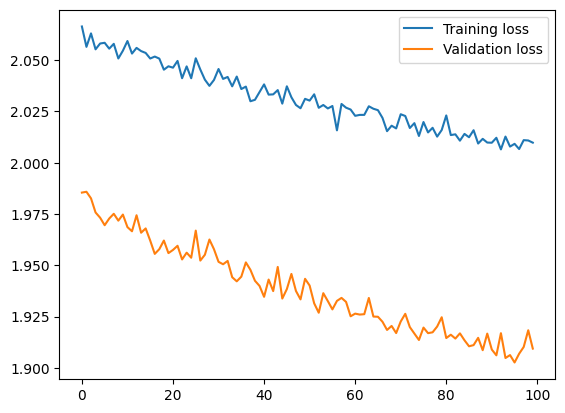

In [24]:
plt.plot(np.array(train_losses), label='Training loss')
plt.plot(np.array(val_losses), label='Validation loss')
plt.legend()
plt.show()

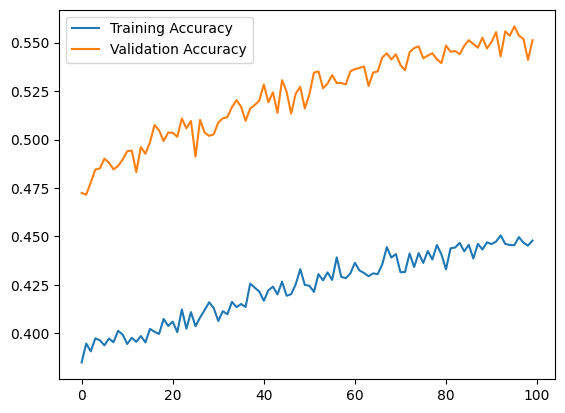

In [25]:
plt.plot(np.array(train_accuracy), label='Training Accuracy')
plt.plot(np.array(val_accuracy), label='Validation Accuracy')
plt.legend()
plt.show()

In the following, we will evaluate the last epoch on the test dataset and calculate the accuracy, look at some outputs and the confusion matrix.

In [26]:
# predicting labels for test data and calculating accuracy
correct = 0
total = 0
test_preds = []
test_labels = []
test_images = []
# since we're not training, we don't need to calculate the gradients for our outputs
with torch.no_grad():
    for data in testloader:
        images, labels = data
        # calculate outputs by running images through the network
        outputs = model(images.to(device))
        # the class with the highest energy is what we choose as prediction
        _, predicted = torch.max(outputs.data, 1)
        test_preds.append(predicted.cpu())
        test_labels.append(labels.cpu())
        test_images.append(images.cpu())
        total += labels.size(0)
        correct += (predicted.cpu() == labels).sum().item()
    test_preds = torch.cat(test_preds).numpy()
    test_labels = torch.cat(test_labels).numpy()
    test_images = torch.cat(test_images)

print(f'Accuracy of the network on the {total} test images: {100 * correct // total} %')

Accuracy of the network on the 10000 test images: 55 %


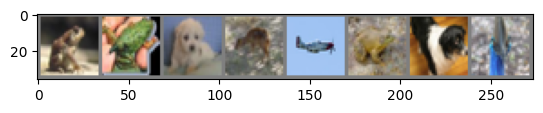

Truth:      frog  frog  dog   deer  plane frog  dog   bird 
Predicted:  frog  frog  deer  frog  plane frog  dog   bird 


In [27]:
images_to_plot = 8

# show images
imshow(torchvision.utils.make_grid(test_images[:images_to_plot]))
# print labels
print('Truth:     ', ' '.join(f'{classes[test_labels[j]]:5s}' for j in range(images_to_plot)))
print('Predicted: ', ' '.join(f'{classes[test_preds[j]]:5s}' for j in range(images_to_plot)))

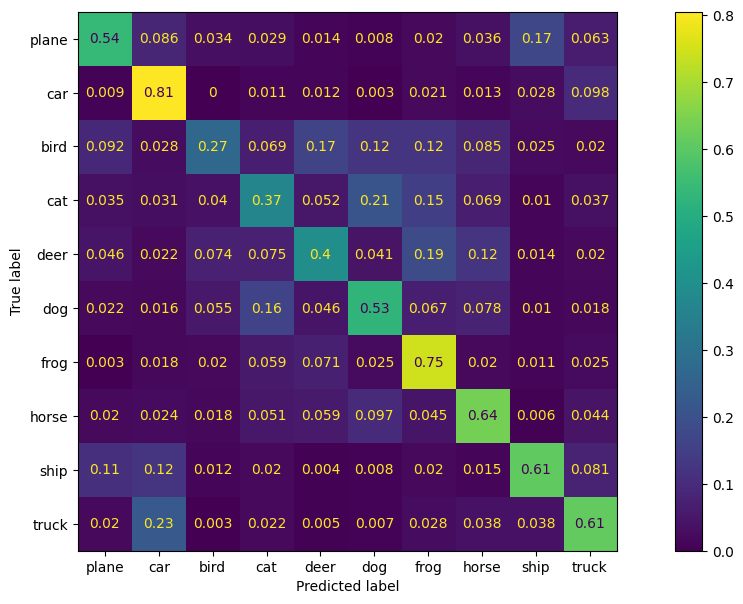

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Create confusion matrix and normalizes it over true labels
confusion = confusion_matrix(test_labels, test_preds, normalize='true')

# Create a plot of the confusion matrix
fig, ax = plt.subplots(figsize=(15, 7))
ConfusionMatrixDisplay(confusion, display_labels=classes).plot(ax=ax)
plt.show()

# Task

**Create a CNN that achieves a validation accuracy of at least 70%**

- Feel free to experiment on the network structure yourself. Use a combination of convolutional and pooling layers, similar to the first exercise.
- If your train and validation metrics diverge, you should consider including [Dropout layers](https://pytorch.org/docs/stable/generated/torch.nn.Dropout.html).

# Possible next steps

- A network with many parameters may perform better but a small network is trained faster and requires less computing resources. Can you reach the 70% validation accuracy in less than 20 epochs?
- The dataset does not only contain Cat and Dog pictures but 10 classes in total. You could rebuild the model as a multi-classifier. To achieve this, you would need to:
    - Include additional classes in your input. Do this by commenting out the one line of code in the data loading section.
    - What else do you need to change to make the model a multi-classifier?
    - Try to achieve the best validation accuracy you can. Which other parameters besides the architecture can you change to affect the performance?